    min_samples_split  TrainScore  TestScore
0                   2      0.8529     0.7100
1                   4      0.8529     0.7100
2                   6      0.8529     0.7100
3                   8      0.8510     0.7100
4                  10      0.8454     0.7229
5                  12      0.8454     0.7229
6                  14      0.8454     0.7229
7                  16      0.8454     0.7229
8                  18      0.8417     0.7229
9                  20      0.8399     0.7359
10                 22      0.8380     0.7403
11                 24      0.8380     0.7403
12                 26      0.8324     0.7403
13                 28      0.8287     0.7403
14                 30      0.8194     0.7619
15                 32      0.8194     0.7619
16                 34      0.8194     0.7619
17                 36      0.8194     0.7619
18                 38      0.8194     0.7619
19                 40      0.8194     0.7619
20                 42      0.8194     0.7619
21        

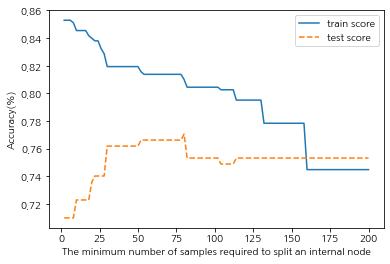

<Figure size 2160x2160 with 0 Axes>

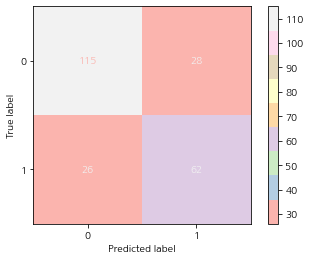

                                             Feature  Importance
6  Plasma glucose concentration a 2 hours in an o...       0.574
2    Body mass index (weight in kg/(height in m)^2).       0.213
1                                       Age (years).       0.165
3                        Diabetes pedigree function.       0.029
7                   Triceps skinfold thickness (mm).       0.019
0                    2-Hour serum insulin (mu U/ml).       0.000
4                  Diastolic blood pressure (mm Hg).       0.000
5                          Number of times pregnant.       0.000


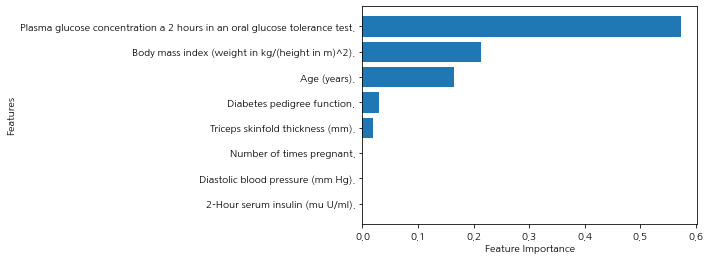

In [41]:
# 참고: https://heytech.tistory.com/150#%EB%-D%BC%EC%-D%B-%EB%B-%-C%EB%-F%AC%EB%A-%AC%--Import
import numpy as np # 벡터, 행렬 등 수치 연산을 수행하는 선형대수 라이브러리
import pandas as pd # 시리즈, 데이터프레임 포맷 데이터 처리를 위한 라이브러리
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리
import warnings; warnings.filterwarnings(action='ignore') # 경고 메시지 무시
import pickle # 객체 입출력을 위한 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # 훈련 데이터, 테스트 데이터 분리
from sklearn.preprocessing import StandardScaler # 정규화
from sklearn.ensemble import RandomForestClassifier as RFC # 랜덤포레스트 분류 알고리즘
from sklearn.tree import DecisionTreeClassifier as DTC # 의사결정나무 분류 알고리즘
from sklearn.ensemble import GradientBoostingClassifier as GBC # 그래디언트 부스팅 분류 알고리즘
# 모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# 데이터 불러오기
data = pd.read_csv("data_week12.csv")
# 데이터 확인
data.head()

# 결측치 없음 확인
#data.isnull().sum() 

# 데이터 스케일링
# - 표준 스케일러 (평균 0, 분산 1)
scaler = StandardScaler()
# 설명변수 및 목표변수 분리
x = data[data.columns.difference(['Class variable (0 or 1).'])]
y = data['Class variable (0 or 1).']
# 설명변수 데이터 스케일링
x_scaled = scaler.fit_transform(x)


# 학습, 테스트 데이터셋 7:3 비율로 분리
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, 
                                                    test_size = 0.3, random_state = 123)


# 하이퍼파라미터별 모델 성능 시각화 함수
def optimi_visualization(algorithm_name, x_values, train_score, test_score, xlabel, filename):
    # 하이퍼파라미터 조정에 따른 학습 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, train_score, linestyle = '-', label = 'train score')
    # 하이퍼파라미터 조정에 따른 테스트 데이터셋 기반 모델 성능 추이 시각화
    plt.plot(x_values, test_score, linestyle = '--', label = 'test score')
    plt.ylabel('Accuracy(%)') # y축 라벨
    plt.xlabel(xlabel) # x축 라벨
    plt.legend() # 범례표시
    plt.savefig('./figure/' + algorithm_name + '_' + filename + '.png') # 시각화한 그래프는 로컬에 저장
    
def optimi_estimator(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_estimator_min, n_estimator_max):
    train_score = []; test_score =[]
    para_n_tree = [n_tree*5 for n_tree in range(n_estimator_min, n_estimator_max)]

    for v_n_estimators in para_n_tree:
        model = algorithm(n_estimators = v_n_estimators, random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 트리 개수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'n_estimators': para_n_tree, 'TrainScore': train_score, 'TestScore': test_score})
    # 트리 개수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_n_tree, train_score, test_score, "The number of estimator", "n_estimator")
    print(round(df_score_n, 4))
    
def optimi_minsplit (algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_split_min, n_split_max, n_estimator, n_depth):
    train_score = []; test_score = []
    para_split = [n_split*2 for n_split in range(n_split_min, n_split_max)]
    for v_min_samples_split in para_split:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_split = v_min_samples_split,
                              max_depth = n_depth,
                              random_state = 1234)
        else:
            model = algorithm(min_samples_split = v_min_samples_split,
                              n_estimators = n_estimator,
                              max_depth = n_depth,
                              random_state = 1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 분리 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_split': para_split, 'TrainScore': train_score, 'TestScore': test_score})
    # 분리 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_split, train_score, test_score, "The minimum number of samples required to split an internal node", "min_samples_split")
    print(round(df_score_n, 4))
    
def optimi_minleaf(algorithm, algorithm_name, x_train, y_train, x_test, y_test, n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split):
    train_score = []; test_score = []
    para_leaf = [n_leaf*2 for n_leaf in range(n_leaf_min, n_leaf_max)]

    for v_min_samples_leaf in para_leaf:
        # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
        if algorithm == DTC:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                        max_depth = n_depth,
                                        min_samples_split = n_split,
                                        random_state=1234)
        else:
            model = algorithm(min_samples_leaf = v_min_samples_leaf,
                                n_estimators = n_estimator,
                                max_depth = n_depth,
                                min_samples_split = n_split,
                                random_state=1234)
        model.fit(x_train, y_train)
        train_score.append(model.score(x_train, y_train))
        test_score.append(model.score(x_test, y_test))

    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 저장
    df_score_n = pd.DataFrame({'min_samples_leaf': para_leaf, 'TrainScore': train_score, 'TestScore': test_score})
    # 잎사귀 노드의 최소 자료 수에 따른 모델 성능 추이 시각화 함수 호출
    optimi_visualization(algorithm_name, para_leaf, train_score, test_score, "The minimum number of samples required to be at a leaf node", "min_samples_leaf")
    print(round(df_score_n, 4))
    
# 랜덤포레스트 분류 알고리즘
# algorithm = RFC
# algorithm_name = 'rfc'
# 의사 결정 모델
algorithm = DTC
algorithm_name = 'dtc'

# 1. Random Forest 모델의 학습할 트리 개수 선정
# n_estimator_min = 1
# n_estimator_max = 31
# optimi_estimator(algorithm, algorithm_name, 
#                  x_train, y_train, x_test, y_test, 
#                  n_estimator_min, n_estimator_max)

n_estimator = 30

# 2. Random Forest 모델의 최대 깊이 선정

# depth_min = 1
# depth_max = 21
# optimi_maxdepth(algorithm, algorithm_name, 
#                 x_train, y_train, x_test, y_test, 
#                 depth_min, depth_max, n_estimator)

n_depth = 6

# 3. 분리 노드의 최소 자료 수
# n_split_min = 1
# n_split_max = 101
# 데이터프레임 행 최대 100개까지 반드시 출력
# pd.set_option('display.max_row', 100)
# optimi_minsplit (algorithm, algorithm_name,
#                  x_train, y_train, x_test, y_test,
#                  n_split_min, n_split_max, n_estimator, n_depth)
n_split = 66 

# 4. 잎사귀 노드의 최소 자료 수 
# - 잎사귀 노드의 최소 자료수 선정
# n_leaf_min = 1
# n_leaf_max = 51
# optimi_minleaf(algorithm, algorithm_name, 
#                x_train, y_train, x_test, y_test, 
#                n_leaf_min, n_leaf_max, n_estimator, n_depth, n_split)

n_leaf = 40

def model_final(algorithm, algorithm_name, feature_name, x_train, y_train, x_test, y_test, n_estimator, n_depth, n_split, n_leaf):
    # 의사결정나무 모델의 경우 트리 개수를 따로 설정하지 않기 때문에 RFC, GBC와 분리하여 모델링
    if algorithm == DTC:
        model = algorithm(random_state=1234, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    else:
        model = algorithm(random_state = 1234, 
                          n_estimators = n_estimator, 
                          min_samples_leaf = n_leaf,
                          min_samples_split = n_split, 
                          max_depth = n_depth)
    # 모델 학습
    model.fit(x_train, y_train)
    # 모델 저장
    model_path = './model/'
    model_filename = 'week12_classification_' + algorithm_name + '.pkl'
    with open(model_path + model_filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"최종 모델 저장 완료! 파일 경로: {model_path + model_filename}\n")
    
    # 최종 모델의 성능 평가
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    y_pred = model.predict(x_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}") # 정확도
    print(f"Precision: {precision_score(y_test, y_pred):.3f}") # 정밀도
    print(f"Recall: {recall_score(y_test, y_pred):.3f}") # 재현율
    print(f"F1-score: {f1_score(y_test, y_pred):.3f}") # F1 스코어
    
    # 혼동행렬 시각화
    plt.figure(figsize =(30, 30))
    plot_confusion_matrix(model, 
                         x_test, y_test,
                         include_values = True,
                         display_labels = ['0', '1'], # 목표변수 이름
                         cmap = 'Pastel1') # 컬러맵
    plt.savefig('./figure/' + algorithm_name + '_confusion_matrix.png') # 혼동행렬 자료 저장
    plt.show()
    
    # 변수 중요도 산출
    dt_importance = pd.DataFrame()
    dt_importance['Feature'] = feature_name # 설명변수 이름
    dt_importance['Importance'] = model.feature_importances_ # 설명변수 중요도 산출

    # 변수 중요도 내림차순 정렬
    dt_importance.sort_values("Importance", ascending = False, inplace = True)
    print(dt_importance.round(3))
    # 변수 중요도 오름차순 정렬
    dt_importance.sort_values("Importance", ascending = True, inplace = True)
    # 변수 중요도 시각화
    coordinates = range(len(dt_importance)) # 설명변수 개수만큼 bar 시각화
    plt.barh(y = coordinates, width = dt_importance["Importance"])
    plt.yticks(coordinates, dt_importance["Feature"]) # y축 눈금별 설명변수 이름 기입
    plt.xlabel("Feature Importance") # x축 이름
    plt.ylabel("Features") # y축 이름
    plt.savefig('./figure/' + algorithm_name + '_feature_importance.png') # 변수 중요도 그래프 저장
    

feature_name = x.columns.values.tolist()
# 최종 모델 학습
model_final(algorithm, algorithm_name, feature_name,
            x_train, y_train, x_test, y_test,
            n_estimator, n_depth, n_split, n_leaf)